<h2><center>Etiquetado Automatico de Imagenes mediante Redes Neuronales CNN y LSTM.</center></h2>


                        
<h4>Referencias</h4>

1. Imagenes tomadas de https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
2. Etiquetas tomadas de https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
3. Curso Mineria de Datos - Por Alvaro Mauricio Montenegro, Universidad Nacional de Colombia, Junio 2020
4. Kumari, K. & Mouneeshwari, C. & Udhaya, R. & Jasmitha, R.. (2020). Automated Image Captioning for Flickr8K Dataset.         
5. Mao, Junhua et al. “Explain Images with Multimodal Recurrent Neural Networks.” ArXiv abs/1410.1090 (2014): n. pag.
6. https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
7. https://colab.research.google.com/drive/1oCNkdbBuh6AlhB4zfyuUPMN5rAfRJ881
8. https://unipython.com/como-preparar-los-datos-de-la-revision-de-la-pelicula-para-el-analisis-de-los-sentimientos/



In [1]:
#### Importe de Librerias a Usar

import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add


Using TensorFlow backend.
C:\Users\HOME PC\anaconda3\lib\site-packages\ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\HOME PC\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()


<h3><center>Esquema del Proyecto<center><h3>
    

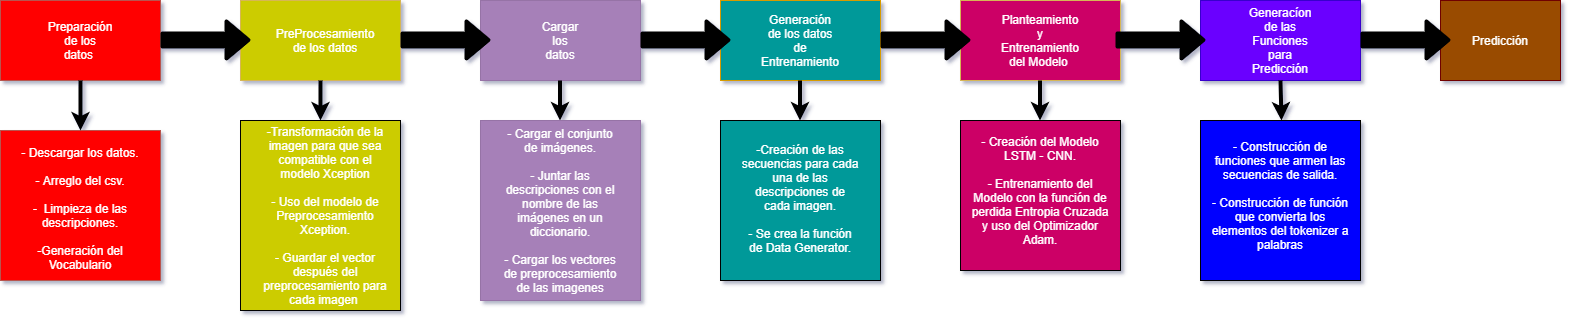

Lo primero que se realizara es escribir unas funciones que seran necesarias a lo largo del proyecto para hacer la red neuronal.

$\textbf{load_doc}$: Lee el archivo de texto y convierte el contenido en un string.

$\textbf{all_img_captions}$: Esta función creara un diccionario donde a cada uno de los nombres de la imagen se le corresponderan las 5 descripciones que le corresponden.

$\textbf{cleaning_text}$: Esta función analizara las descripciones en el diccionario creado con la función all_img_captions y quitara preposiciones, puntos,comas o números a las mismas para hacer una limpieza.

$\textbf{text_vocabulary}$: Esta función separara las palabras que no se repiten y creara un vocabulario con todas las descripciones.

$\textbf{save_descriptions}$: Esta función creara una lista de todas las descripciones que fueron preprocesadas con las funciones anteriores y las guardara en un archivo de texto txt. 

$\textbf{load_photos}$: Este archivo leera el archivo de texto donde se encuentra el nombre de las imagenes y lo convertira en una lista.



$\textbf{load_clean_descriptions}$: Esta función creara un diccionario que va a contener las descripciones de de cada una de las imagenes, para toda la lista de imagenes creada anteriormente, tambien se añadira un start y end a cada una de las descripciones, esto sera necesitado para el planteamiento de la red LSTM más adelante.

$\textbf{load_features}$: Esta función nos dara un diccionario con el nombre de las imagenes asociadas a el vector donde se encuentra el vector preprocesado de las mismas con el modelo Xception.

$\textbf{disc_to_list}$: Esta función convierte las descripciones en listas.

$\textbf{create_tokenizer}$: Crea el tokenizer con respecto a las descripciones

$\textbf{max_length}$: Saca el tamaño maximo de todas las descripciones, esto es necesario para saber de cuantos caracteres sera la prediccion.



Se definiran los paths donde estan los datos para cargarlos tanto de etiqueta como de imagenes

In [5]:
dataset_text = "F:/Unal/2020-1/Mineria/Proyecto/Flickr8k_text"
dataset_images = "F:/Unal/2020-1/Mineria/Proyecto/Flicker8k_Dataset"
filename = dataset_text + "/" + "Flickr8k.token.txt"

A continuación se creara el archivo txt que contendra las descripciones, teniendo en cuenta que a cada una de las imagenes le corresponden 5 descripciones, adicionalmente se hara una limpieza de las descripciones y se creara el vocabulario de las palabras

In [6]:

print("Length of descriptions =" ,len(descriptions))
print("Length of vocabulary = ", len(vocabulary))
descriptions

Length of descriptions = 8092
Length of vocabulary =  8763


{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young 

Ahora se tratara el pre-procesamiento de las imagenes para esto fue usado el modelo de preprocesamiento Xception, esta es una de las alternativas que tiene Keras como modelos de pre-procesamiento de imagenes, en otros articulos y trabajos que tratan temás similares es bastante usado y da buenos resultados, las otras alternativas que podemos encontrar en Keras para este trabajo son VCG16, VCG19, Resnet50, Inception V3,entre otros, personalmente seleccione el modelo Xception porque revisando literatura sobre estos modelos de Pre-Procesamiento este es uno de los que tiene mejores resultados. 

A continuación se escribira el codigo para aplicar este modelo de pre-procesamiento a las imagenes del dataset, este procedimiento puede ser bastante demorado CPU (3-6 horas), GPU (30 min- 1 Hora), por lo tanto en la celda de más abajo se carga el archivo de Features que ya fue corrido.
(Referencia:  https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568)  




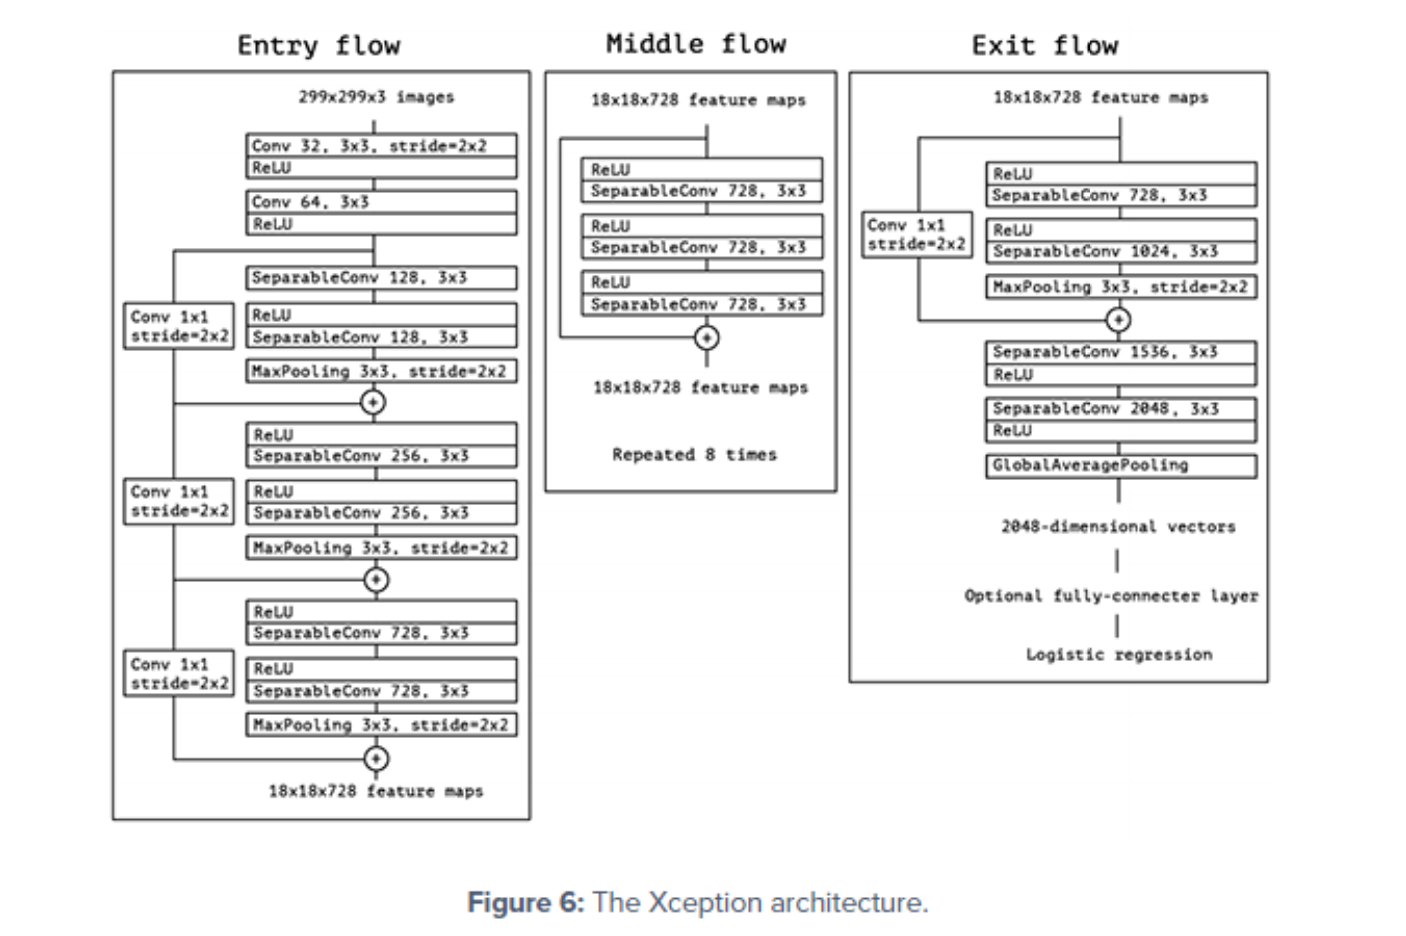

In [2]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
#Longitud del vector de salida : 2048



In [8]:
features = load(open("F:/Unal/2020-1/Mineria/features.p","rb"))

Ahora se cargaran las descripciones, imagenes y el vector de 2048 que resulto del pre-procesamiento, con estos armaremos los archivos para el training del modelo.

In [11]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)


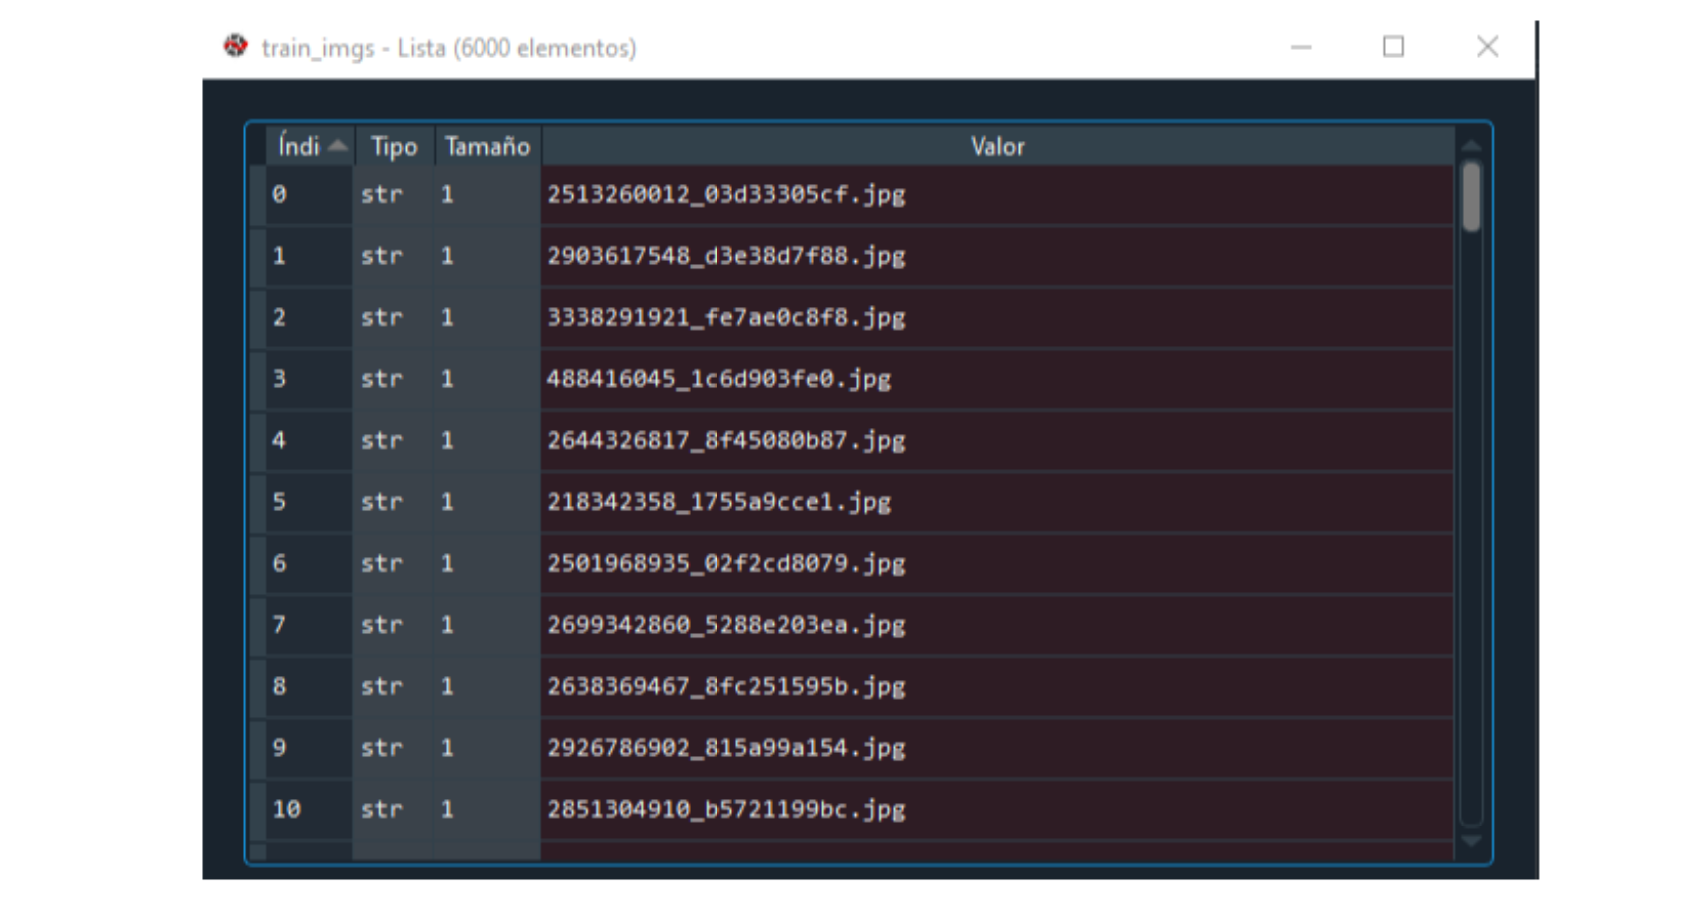

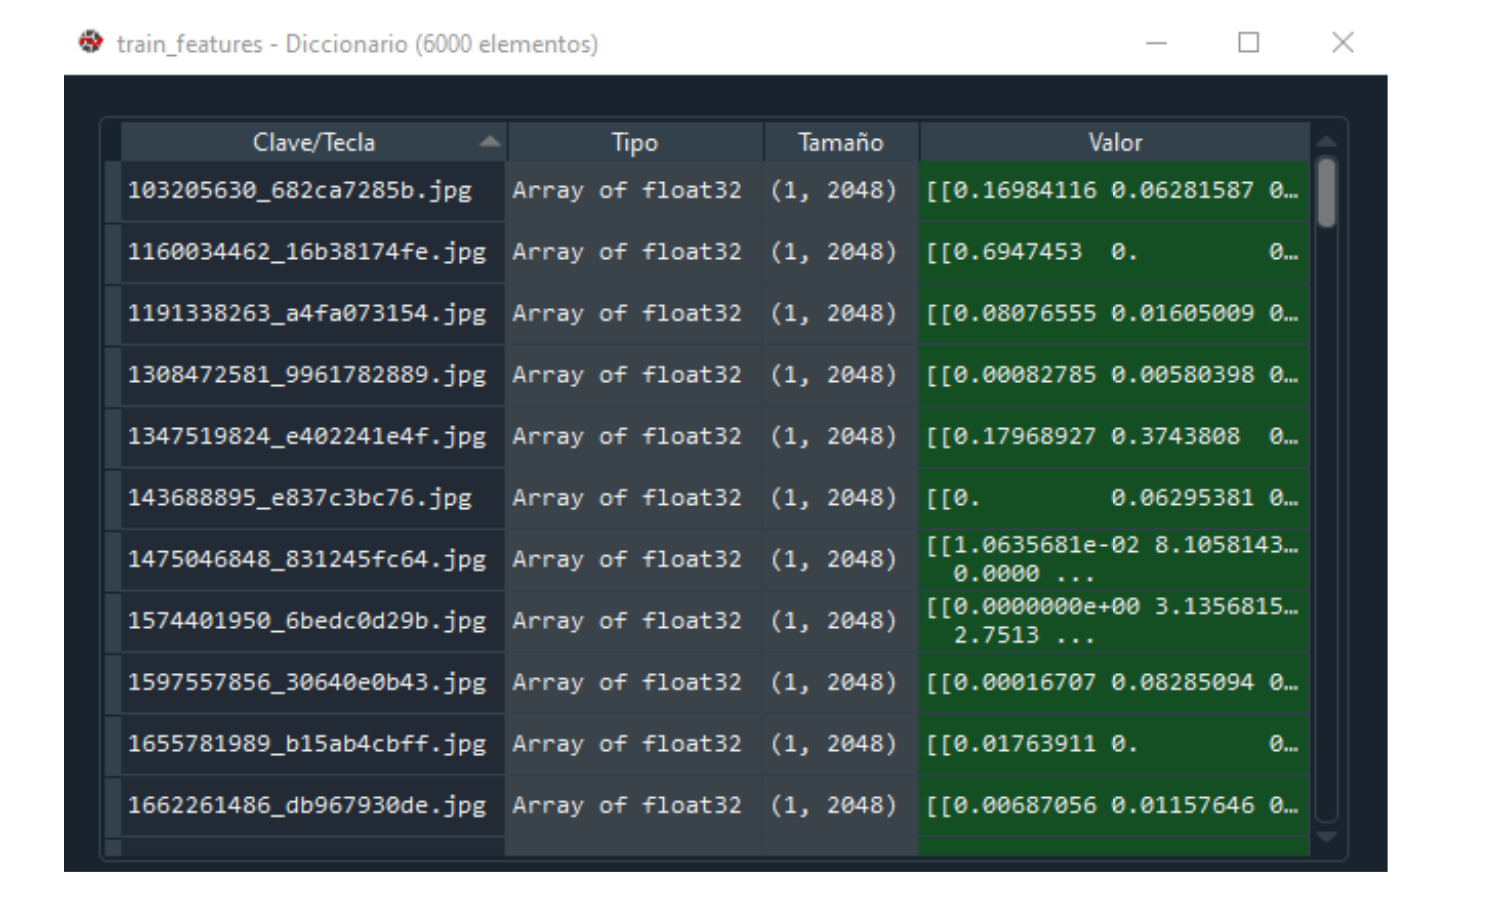

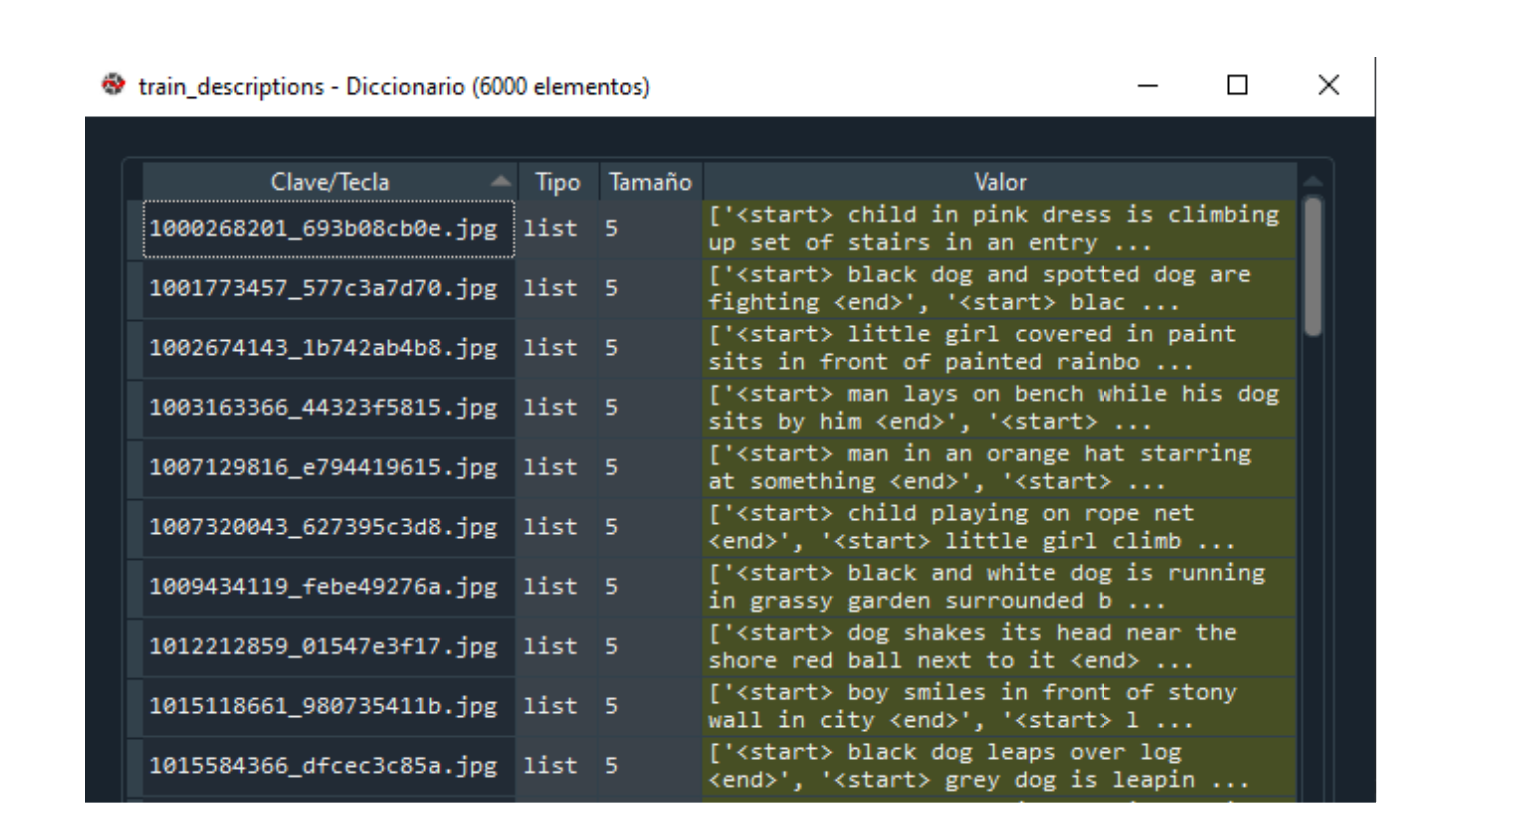

Ahora en el modelo no es posible usar las palabras, por lo tanto es necesario que sean representadas por números para esto se creara un tokenizer, lo que hara es asignar números a las palabras del vocabulario que creamos anteriormente y esto se hace mediante la funcíon de Keras, luego este tokenizer se va a guardar como un archivo pickle.


In [12]:

tokenizer.word_index

{'end': 1,
 'start': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'brown': 24,
 'young': 25,
 'red': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'down': 35,
 'shirt': 36,
 'ball': 37,
 'standing': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'sitting': 47,
 'front': 48,
 'field': 49,
 'holding': 50,
 'small': 51,
 'yellow': 52,
 'green': 53,
 'group': 54,
 'up': 55,
 'by': 56,
 'large': 57,
 'one': 58,
 'walking': 59,
 'her': 60,
 'men': 61,
 'children': 62,
 'air': 63,
 'into': 64,
 'near': 65,
 'mouth': 66,
 'beach': 67,
 'jumps': 68,
 'runs': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'from': 73,
 'its': 74,
 'riding': 75,


El vocabulario que hicimos anteriormente tiene 7577 palabras, que fueron convertidas a números y guardadas en el tokenizer, con el fin de lograr hacer una predicción más precisa vamos a calcular la cantidad de palabras que tienen las descripciones, esto con el fin de que al hacer una predicción futura no exceda esta cantidad de palabras.

In [13]:
max_length



32

Ahora se hara uso del Data-Generator, esto es debido a la naturaleza del modelo (CNN-LSTM) que se usara, y a la naturaleza de los datos, tenemos que para cada imagen se tienen un vector de tamaño 2048 resultado del pre-procesamiento con el modelo Xception, y se tienen 5 descripciones, que a su vez cada una contienen un número determinado de palabras, entonces lo que se hara es descomponer cada una de estas descripciones en palabras. Por ejemplo:

sea la imagen cuya descripción es una niña salta en parque, esta sera su descomposición






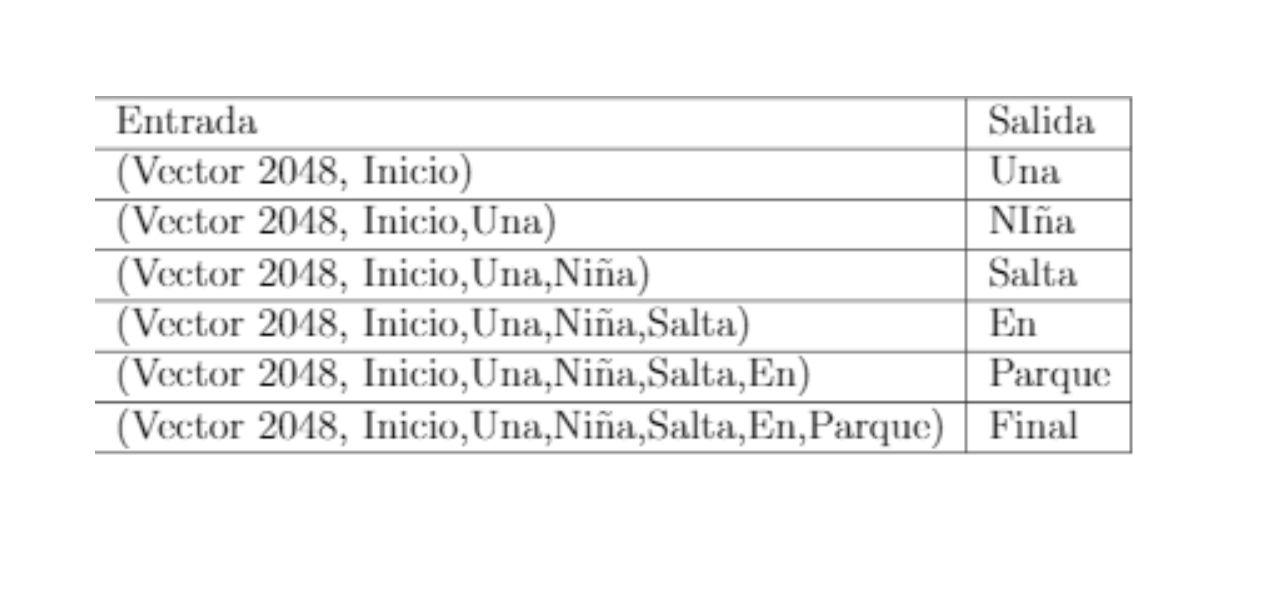

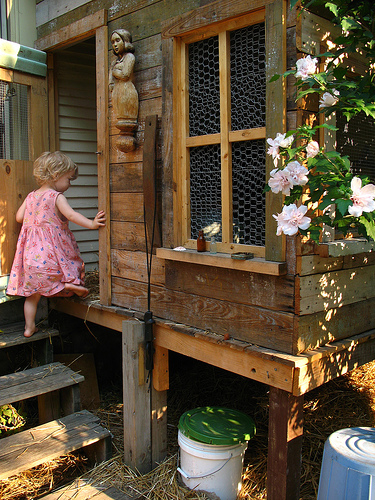 

Cuya primera descripción es start child in pink dress is climbing up set of stairs in an entry way end




y Esta descripción se ve reflejada en la siguiente secuencia creada por el data-generator y con el tokenizer que se creo antes.

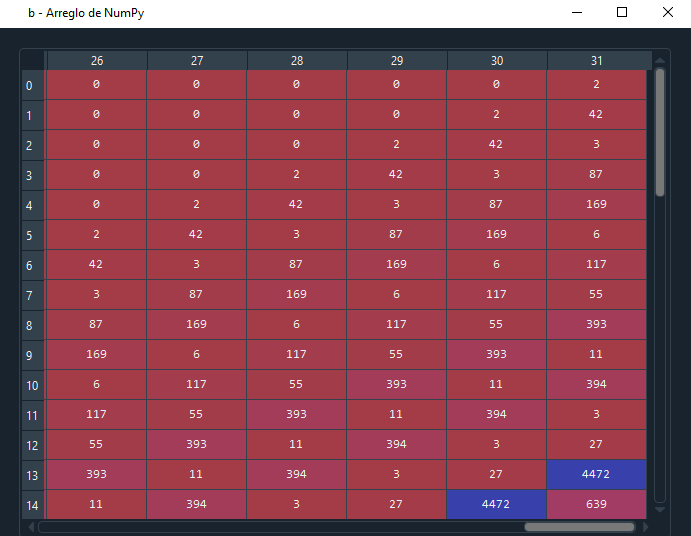

<h1><center>Modelo<center></h1>

Ahora se definira el modelo, como se comento anteriormente el modelo usado sera un Convolutional Neuronal Network- Long Short Term Memory, este modelo esta definido en dos partes principales, la primera parte el modelo CNN se encargara de hacer el tratamiento de las imagenes pre-procesadas por el modelo Xception aqui se definira un Dropout (0.3) y luego una capa densa. La otra parte consistira en el modelo LSTM, el cual se encargara de procesar la parte de las descripciones de las imagenes con las secuencias que se definieron con el Data Generator, este modelo LSTM consta con un embedding,luego un Dropout (0.3) y luego la capa LSTM,  despues de esto la capa de salida del Modelo LSTM y la capa de salida del Modelo CNN seran la entrada de otro modelo el cual consta con 3 capas densas en el cual se combinaran las salidas de la red LSTM y de la red CNN, y la ultima capa de este modelo nos dara la prediccion de la palabra. El siguiente gráfico puede ilustrar de manera más simple como funciona.



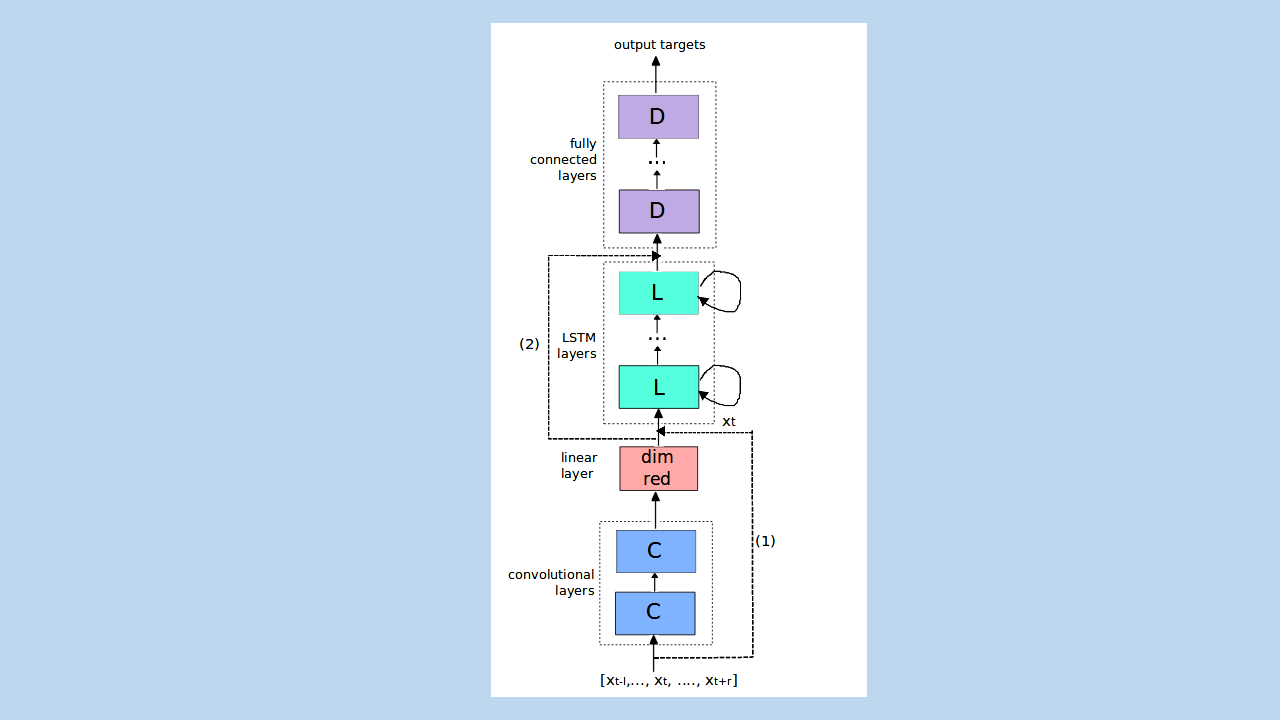



Ahora se pasara al entrenamiento del modelo, para el mismo se usaran 6000 imagenes de entrenamiento a las cuales se les generaron las secuencias de entrada y salida que se hicieron con el data_generator, esto toma alrededor de (1-2 horas) en correr.



In [17]:
#Modelo
model = define_model(vocab_size, max_length)

print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 256)      1939712     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropo

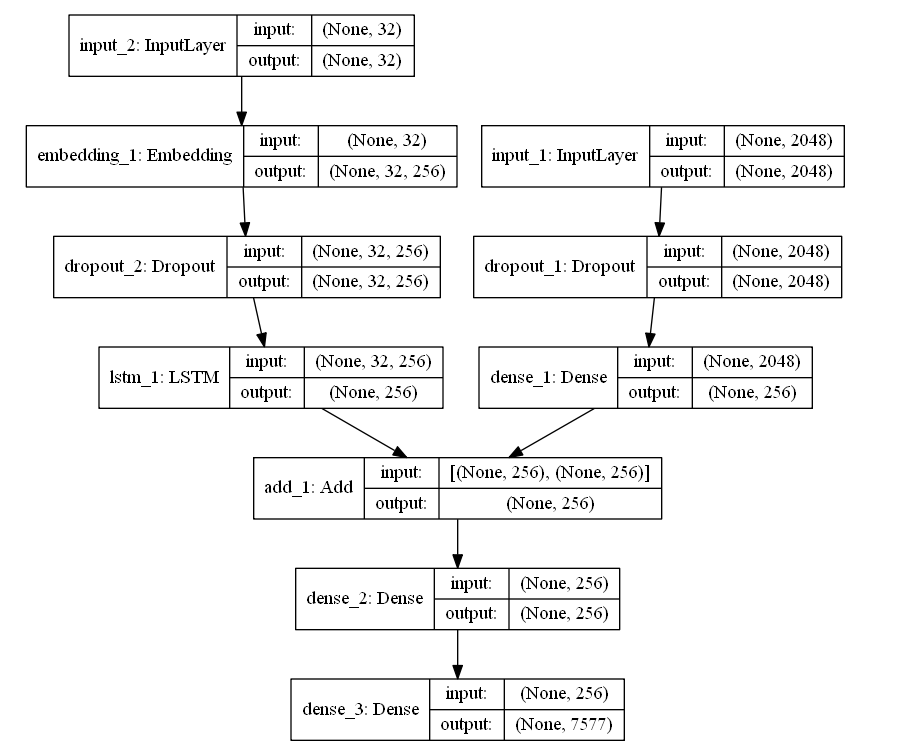

In [ ]:
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    history=model.fit_generator(generator, epochs=epochs, steps_per_epoch= steps, verbose=1)

<h3><center>Test-Predicción del Modelo.</center><h3>



Ahora se hara la parte del test del modelo, para esto vamos a cargar imagenes que no fueron entrenadas en la red y la red va a generar una descripción para las mismas, sin embargo se debe tener en cuenta que de igual manera como se hizo en el data_generator, la red va a predecir una palabra cada vez que hagamos una predicción por lo tanto la primera palabra de la secuencia sera start, luego se introducira la imagen pre-procesada y la secuencia que corresponda a start al modelo para que prediga la siguiente palabra y asi sucesivamente. 

Para esto vamos a definir las siguientes funciones.

$\textbf{extract_features}$: Tomara la imagen y aplicara el preprocesamiento mediante el modelo Xception (Aunque hay más modelos disponibles es preferible usar este debido que con este se entrenaron los datos).

$\textbf{word_for_id}$: Hara el proceso inverso que se hizo en el tokenizer, puesto que la predicción de la red sera el número que corresponde en el tokenizer por lo tanto está función transformara el número a la palabra correspondiente.

$\textbf{generate_desc}$: Hara el proceso para generar la descripción completa de la imagen como se explico más arriba.

In [22]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

Ahora se procedera a hacer el test con una imagen que no ha sido usada en el entrenamiento de la red, primero se carga el modelo que guardamos y el tokenizer, además de especificar el modelo Xception.

In [26]:

max_length = 32
tokenizer = load(open("F:/Unal/2020-1/Mineria/tokenizer.p","rb"))
model = load_model('F:/Unal/2020-1/Mineria/models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

start motorcycle racer is riding on the track end


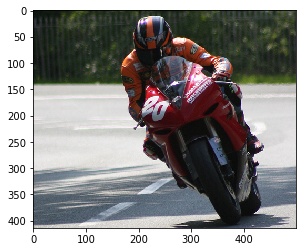

In [31]:

print(description)
plt.imshow(img)

start man is sitting on the edge of waterfall end


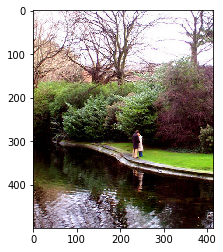

In [32]:

print(description)
plt.imshow(img2)


start brown dog is running through the grass end


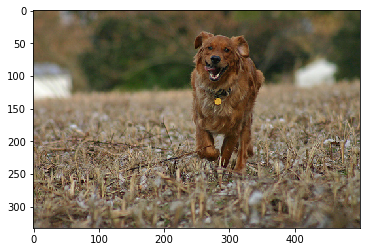

In [34]:

print(description)
plt.imshow(img3)


start boy in red and white uniform kicks soccer ball end


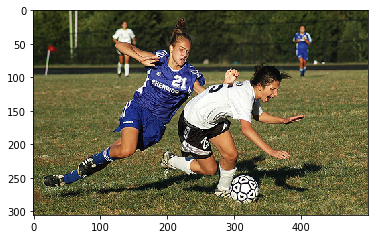

In [36]:

print(description)
plt.imshow(img4)

Como se puede ver las descripciones generadas son coherentes en las 4 imagenes, sin embargo se tienen errores y estas podrian ser más precisas, teniendo en cuenta que estas imagenes no estuvieron en los datos de entrenamiento los resultados son bastante correctos, sin embargo para tener una mayor precisión y usar este tipo de redes en entornos profesionales como productos o demás seria necesario hacerlo con un set de imagenes mucho mayor, puesto que entre mayor sea el número de imagenes mejor van a ser las descripciones y asi mismo seran más detalladas.